# Mean-Absolute Deviation-Entropy Multi-Objective Goal-Programming Portfolio Optimization Model

**Quantitative Finance** overlaps heavily with **Operations Research**. Indeed, **Mathematical Optimization** serves investors well in improving their **Portfolio Management** practices. We will address the need for minimization of the unsystematic risk in portfolio-building pointed out by the Covid-19-related financial crisis, while addressing the classic risk-return trade-off. We will use a **goal-programming** approach to solve a **multi-objective** model to optimize the Mean-Absolute Deviation-Entropy antagonist criteria.

***
**Packages Requirements**

In [1]:
# Requirements instalation
Requirements  = 0
if Requirements == 1:
    !pip install pandas
    !pip install pandas-datareader
    !pip install plotly==5.3.1
    !pip install docplex
    !pip install seaborn
    !pip install statsmodels
    !pip install numpy
    !pip install matplotlib

In [2]:
# Raw Packages
import math
import random
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Packages
from docplex.mp.model import Model
from pandas_datareader import data,wb
from datetime import date
from scipy.stats import shapiro 
from scipy.stats import kstest

In [4]:
random.seed(101)

***
## Literature Milestones
> *Conducting a literature review on the topic of **Portfolio Optimization** and by extent, the trade-off between return measure and risk measure could be an endless process. However, two scientific papers are considered as milestones in this area of research and heavily changed the landscape of industry-used models. We will also briefly mention Shannon's Entropy publication as this part is key to our model.*
> <br/><br/>
> **Mean Variance (MV): Markowitz**
>  <br/><br/>
>Harry Markowitz's *"Portfolio Selection"* paper published in 1952 in the Journal of Science is widely referred to as the very first milestone in the field of portfolio optimization and portfolio selection. As of today, a majority of contemporary models in this field have been derived from principles that Markowitz established in this paper *(Markowitz's, 1952)*.
>
>Markowitz introduces the Mean-Variance (MV) model for portfolio selection. Up to this date, most models focused on maximizing expected or anticipated returns of a portfolio regardless of the risk factor, which fully ignores the highly critical diversification factor of portfolio construction leading to risk exposure. Markowitz introduced the idea of considering both expected return and variance to influence investment behaviour. Variance would be a measure of risk or diversification in this context. This paper provides (with simple mathematical proof), a formulation of such a model based on random-variables series properties. Of course, the author acknowledged the possibility of utilizing a different measure of risk and diversification than variance (i.e., the standard deviation and the coefficient of variation). The objective function is therefore defined as $E-V$ with $E$ being the expected return from the portfolio as a whole and $V$ being the variance.
>
> This article does not describe the computation techniques that leads to the definition of the attainable set of $(E,V)$ combinations. Rather, it describes in simplified geometric space how the investor's preferences of return impact the definition of the set of efficient portfolios based on isomean and isovariance curves of the set of solutions.This is the underlying proof that his $E-V$ rule take into consideration industry diversification over simple "name" diversification while building portfolios.
> <br/><br/>
> **Mean Absolute Deviation (MAD): Konno & Yamazaki**
>  <br/><br/>
> Although Markowitz's Mean-Variance (MV) model provides substantial insight into portfolio optimization on a theoretical level, it has not been widely applied in practice due to the computational difficulty that arises from quadratic programming. Additionally, the Capital Asset Pricing Model (CAPM) derived from Markowitz's theory is not an accurate model either - as most equilibrium models, the CAPM relies on unrealistic assumptions about the relationship between a stock's return and the market's return. 
> 
> In the paper *"Mean-Absolute Deviation Portfolio Optimization Model and Its Applications to Tokyo Stock Market"* published in 1991, Konno and Yamazaki introduce a new portfolio optimization model that employs piecewise linear risk functions known as the Mean-Absolute Deviation (MAD) model *(Konno & Yamazaki, 1991)*. The MAD model can achieve the results of Markowitz's MV model by solving a more simple linear model compared to the complex quadratic model initially proposed. More specifically, Konno and Yamazaki minimize a risk function called the "absolute deviation", instead of the standard deviation function. Given returns are multivariate and normally-distributed, absolute deviation and standard deviation are essentially, the same measures. The difference between using standard deviation and abolsute deviation is that the latter need not calculate a covariance matrix in the problem setup. This simplifies the problem greatly, along with being able to solve a linear problem and not a quadratic one. 
> <br/><br/>
> **Entropy: Shannon**
>  <br/><br/>
> Shannon's paper titled *"A Mathematical Theory of Communication"* published in 1948 addressed the mathematical proof of the use of the entropy measure to assess the level of information or uncertainty of a random variable, given its possible outcomes *(Shannon, 1948)*. Shannon's entropy measure for a random variable $X$ is expressed as follows:<br/>
>
> $\displaystyle \mathrm {H} (X):=-\sum _{x\in {\mathcal {X}}}p(x)\log p(x)=\mathbb {E} [-\log p(X)]$
>
> Since then, many scientific fields made full use of Shannon's paper, mostly to measure uncertainty and diversity. In finance and more particularly, in portfolio managment, Shannon's Diversity Index is therefore a great way to measure a portfolio's unsystematic risk as it measures diversification. Such use leads to new ways of optimizing portfolios: with this knowledge, one can combine expected return, absolute deviation, and entropy. The following will attempt to do exactly this - construct an optimal portfolio that will simultaneously maximize expected return, minimize absolute deviation, and maximize entropy.
>

***
## Data Aquisition
> As with many analytically-driven projects, the first enabler is the data acquisition step. Without clean, complete, and reliable data, meaningful models and analysis are not possible. Luckily, in the field of portfolio optimization,  stock market data is free and easy to access. For the model developed to construct the following portfolio, the only input is the daily returns of the individual stocks listed in the **Dow Jones Industrial Average (DJIA)**, which are listed in the **New York Stock Exchange (NYSE)**.
>
> ### Ticker Collection
> In the finance world, a firm's stock are indicated using a unique ticker symbol. Listing and gathering the tickers to be used within the scope of this project is the first essential step to be completed.

In [5]:
DJIA_tickers = ['AMGN','AXP','BA','CAT','CRM','CSCO','CVX','DIS','GS','HD','HON','IBM','INTC','JNJ','JPM','KO','MCD','MMM','MRK','MSFT','NKE','PG','TRV','UNH','V','VZ','WBA','WMT']

> ### API Connection
> When it comes to retrieving financial data based on tickers, there are numerous options available to achieve such a task in Python. A very common and easy way to do so is to call the **Yahoo Finance's API** over the list of tickers and concatenate results within a Pandas DataFrame as defined in the function below.

In [6]:
def ticker_collection(Tickers, startdate, enddate):

    df_djia_adj_close = pd.DataFrame()

    for ticker in Tickers:
        df_temp = data.DataReader(ticker,'yahoo',startdate, enddate)['Adj Close'].to_frame()
        df_temp = df_temp.rename(columns={'Adj Close': ticker + '_Adj_Close'})
        df_djia_adj_close = pd.concat([df_djia_adj_close, df_temp], axis=1)

    df_djia_adj_close.to_csv('df_djia_adj_close.csv')

> ### API Pull
> For the scope of this study, we will remain within the **DJIA tickers** and pull capital market data from *January 1st 2017* up to *October 14th 2022*.

In [7]:
Tickers = DJIA_tickers
startdate = pd.to_datetime('2016-01-01')
enddate = pd.to_datetime('2022-10-14')

#ticker_collection(Tickers, startdate, enddate)

***
## Data Preparation
> ### Return Computation
> As expressed before, the key input for our model is the return per stock of the DJIA. Therefore, we have to compute the return based on the capital market data that we just pulled. As a reminder, we will only consider capital returns and ignore dividends; return on a stock would then be define as follows:
>
> $R(x) = \frac{P_{t}-P_{t-1}}{P_{t-1}}$

In [8]:
rjt = pd.read_csv('df_djia_adj_close.csv', index_col=[0])
rjt = rjt.drop(['DOW_Adj_Close'], axis = 1)
rjt = rjt.dropna()

In [9]:
def norm_return(rjt):
    rjt['PD_DT_Date'] = rjt.index
    rjt['PD_DT_Date'] = pd.to_datetime(rjt['PD_DT_Date'])
    rjt['Week-Year'] = rjt['PD_DT_Date'].dt.isocalendar().year.astype(str)+rjt['PD_DT_Date'].dt.isocalendar().week.astype(str)
    rjt['Week-Year'] = rjt['Week-Year'].astype(int)
    rjt.index = rjt['Week-Year']
    rjt = rjt.drop(['PD_DT_Date'], axis = 1)
    rjt = rjt.drop(['Week-Year'], axis = 1)
    rjt = rjt.groupby('Week-Year').mean() 

    for j in Tickers:
        rjt[j + '_rjt'] = np.nan
        prev_ind = rjt.index[0]
        for t in rjt.index[1:] :
            rjt[j + '_rjt'][t] = (rjt[j + '_Adj_Close'][t] - rjt[j + '_Adj_Close'][prev_ind]) / rjt[j + '_Adj_Close'][prev_ind]
            prev_ind = t
        rjt = rjt.drop([j + '_Adj_Close'], axis = 1)

    rjt = rjt.dropna()
    return rjt

rjt = norm_return(rjt)

> To adress the *long-term holding* strategy presented in this model (no trading involved) we will also compound the returns over the horizon. 

In [10]:
def comp_return(df_rjt):
    comp_rjt = pd.DataFrame(index=range(len(df_rjt)))
    for j in Tickers:
        comp_rjt[j + '_rjt'] = np.nan
        for i in range(len(df_rjt)):
            if i == 0:
                comp_rjt[j + '_rjt'][i] = 1
            else:
                comp_rjt[j + '_rjt'][i] = comp_rjt[j + '_rjt'][i-1] * (1 + df_rjt[j + '_rjt'].iloc[[i]])

    return comp_rjt

cum_rjt = comp_return(rjt)
rj = cum_rjt.tail(1) - 1

> ### Hypothesis Testing
> The model presented here assumes that returns on stocks are normally distributed. Therefore, we need to confirm this property before going any further. This could be done visually but also more precisely through hypothesis testing. Let's confirm this using **Shapiro-Wilk** test.

In [11]:
#Shapiro-Wilk Test
shapiro(rj)

ShapiroResult(statistic=0.9731341004371643, pvalue=0.6666070818901062)

***
## Model
> Since *Markowitz' 1952* paper, **Portfolio Optimization** falls under the **Multi-Objective** umbrella of **Operations Research** *(Markowitz's, 1952)*. In fact, regardless of the measures used, investors always deal with the well-known return-risk trade-off. Ultimately, this decision is up to the investor based on their preferences, often referred to as "risk profiles". **Goal Programming** is a commonly-used approach for multi-objective optimization. This approach consists of solving an **LP** for every single antithetical objective and storing the optimal solution as a benchmark of the best achievable result with regard to the respective objective. The next step involves minimizing the **"deviations"** of the final solution with every single benchmark. It is necessary to assess every objective in the same unit or same order of magnitude, weights attributed to these objectives can also be fine-tuned to reflect the investors preferences.
>
> ***
> ### Function Definition
> We want to define a callable function to solve an LP for every single objective. Let's begin with the **expected return** and solve the following:
>
> $\displaystyle Maximize\ R(x) = \sum_{j = 1}^{n}\mathbb {E} [R_j]x_j,$ <br/>
> $subject\ to$ <br/>
> $\sum_{j = 1}^{n} x_j = 1$ <br/>
> $ x_j \geq 0, j = 1,...,n$

In [13]:
def solve_expected_return():
    ER = Model('ER')
    T = len(rjt)
    TimePeriods = list(range(1,T))
    N = len(Tickers)
    TickersIndex = list(range(1,N))

    #Decision Variables
    x = ER.continuous_var_dict(TickersIndex, name = "x") #integer_var_matrix(key1,key2)

    #Objective Function
    Objective_Function = ER.sum(x[j]*rj.iloc[0,j-1] for j in TickersIndex)
    ER.maximize(Objective_Function)
    
    #Weights Constraint
    ER.add_constraint(ER.sum(x[j] for j in TickersIndex) == 1)
    
    #Solve the model    
    ER.solve()
    
    #Print results
    print("Maximum Return:", ER.solution.get_objective_value())
    print("Solution: \n", ER.solution.get_value_df(x)['value'])
    return(ER.solution.get_objective_value())

> Now let's turn to the **absolute deviation** and solve the following: 
> 
> $\displaystyle Minimize\ w(x) = \mathbb {E} [	\Bigg |\sum_{j = 1}^{n}R_jx_j - \mathbb {E} [\sum_{j = 1}^{n}R_jx_j]  	\Bigg |]$ <br/>
> $subject\ to$ <br/>
> $\sum_{j = 1}^{n}\mathbb {E} [R_j]x_j \geq \rho$ <br/>
> $\sum_{j = 1}^{n} x_j = 1$ <br/>
> $x_j \geq 0, j = 1,...,n$

In [14]:
def solve_mad_absolute_deviation_NLP(rho):
    MAD = Model('MAD')
    T = len(rjt)
    TimePeriods = list(range(1,T))
    N = len(Tickers)
    TickersIndex = list(range(1,N))

    #Decision Variables
    x = MAD.continuous_var_dict(TickersIndex, name = "x")

    #Objective Function
    Objective_Function = (1/T) * MAD.sum(MAD.abs(MAD.sum(x[j] * (rjt.iloc[t,j-1] - rj.iloc[0,j-1]) for j in TickersIndex)) for t in TimePeriods)
    MAD.minimize(Objective_Function)
    
    #Return Constraint
    MAD.add_constraint(MAD.sum(rj.iloc[0,j-1] * x[j] for j in TickersIndex) >= rho)
    
    #Weights Constraint
    MAD.add_constraint(MAD.sum(x[j] for j in TickersIndex) == 1)
    
    #Solve the model
    MAD.solve()
    
    #Print results
    print("Minimum Absolute Deviation:", MAD.solution.get_objective_value())
    print("Solution: \n", MAD.solution.get_value_df(x)['value'])
    return(MAD.solution.get_objective_value())

> **Note:** The absolute value function is not linear, but easily modelled into a linear equivalent within an LP. CPLEX can handle the above model, but the proper **Linear Model** equivalent is defined in the cell below: 
>
> $\displaystyle Minimize\ \sum_{t = 1}^{T}y_t / T$ <br/>
> $subject\ to$ <br/>
> $y_t + \sum_{j = 1}^{n}(r_jt-r_j)x_j \geq 0$ <br/>
> $y_t - \sum_{j = 1}^{n}(r_jt-r_j)x_j \geq 0$ <br/>
> $\sum_{j = 1}^{n}r_jx_j \geq \rho$ <br/>
> $\sum_{j = 1}^{n} x_j = 1$ <br/>
> $x_j \geq 0, j = 1,...,n$

In [15]:
def solve_mad_absolute_deviation_LP(rho):
    MAD = Model('MAD')
    T = len(rjt)
    TimePeriods = list(range(1,T))
    N = len(Tickers)
    TickersIndex = list(range(1,N))

    #Decision Variables
    x = MAD.continuous_var_dict(TickersIndex, name = "x") #ask keenan for matrix formula
    y = MAD.continuous_var_dict(TimePeriods, name = "y") #ask keenan for matrix formula

    #Objective Function
    Objective_Function = (1/T)*MAD.sum(y[t] for t in TimePeriods)
    MAD.minimize(Objective_Function)
    
    #Positivity Constraints
    for t in TimePeriods:
        MAD.add_constraint(y[t] + MAD.sum(x[j] * (rjt.iloc[t,j-1] - rj.iloc[0,j-1]) for j in TickersIndex) >= 0)
        MAD.add_constraint(y[t] - MAD.sum(x[j] * (rjt.iloc[t,j-1] - rj.iloc[0,j-1]) for j in TickersIndex) >= 0)
    
    #Return Constraint
    MAD.add_constraint(MAD.sum(rj.iloc[0,j-1] * x[j] for j in TickersIndex) >= rho)
    
    #Weights Constraint
    MAD.add_constraint(MAD.sum(x[j] for j in TickersIndex) == 1)
    
    #Solve the model
    MAD.solve()
    
    #Print results
    print("Minimum Absolute Deviation:", MAD.solution.get_objective_value())
    print("Solution: \n", MAD.solution.get_value_df(x)['value'])
    #print("Annex Variable Y Value: \n", MAD.solution.get_value_df(y))
    return(MAD.solution.get_objective_value())

> ### Goal 1: Maximize Return
> By calling the previously defined function, we can now collect the expected return "**Goal Benchmark**", $R*$.

In [16]:
R_Star = solve_expected_return()

Maximum Return: 2.2866249702608155
Solution: 
 0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    1.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
Name: value, dtype: float64


> ### Goal 2: Minimize Absolute Deviation
> By calling the previously defined function, we can now collect the absolute deviation "**Goal Benchmark**", $W*$. Given an overall performance of roughly $100\%$ for the **DJIA** over the horizon of the study we arbitrarily chose to fix $\rho = 0.5$.

In [17]:
W_Star = solve_mad_absolute_deviation_LP(rho = 0.5) 

#Equivalent
#W_Star = solve_mad_absolute_deviation_NLP(rho = 0.5)

Minimum Absolute Deviation: 0.493851843547397
Solution: 
 0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.857820
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.086043
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.056137
Name: value, dtype: float64


> ### Goal 3: Maximize Entropy
> We can now collect the diversification "**Goal Benchmark**", $\ln(n)$.

In [18]:
Lnn = math.log(len(Tickers))
print(Lnn)

3.332204510175204


> ***
> ### Multi-Objective Model - Without Entropy
> If we were to use the goal programming approach to solve the MAD multi-objective model, we would minimize the following deviation:
>
> $\displaystyle Minimize\ Z = \alpha\Bigg |\frac{d1}{R*}\Bigg | + \beta\Bigg |\frac{d2}{W*}\Bigg |$ <br/>
> $subject\ to$ <br/>
> $R(x) + d1 = R*$ <br/>
> $W(x) - d2 = W*$ <br/>
> $\sum_{j = 1}^{n} x_j = 1$ <br/>
> $x_j \geq 0, j = 1,...,n$

In [19]:
print(R_Star)
print(W_Star)

2.2866249702608155
0.493851843547397


In [20]:
def solve_made(R_Star, W_Star, Alpha, Beta, Print):
    MADE = Model('MADE', log_output=False)
    T = len(rjt)
    TimePeriods = list(range(1,T))
    N = len(Tickers)
    TickersIndex = list(range(1,N))

    #Decision Variables
    x = MADE.continuous_var_dict(TickersIndex, name = "x")
    y = MADE.continuous_var_dict(TimePeriods, name = "y")
    d1 = MADE.continuous_var(name = "d1", lb = 0)
    d2 = MADE.continuous_var(name = "d2", lb = 0)

    #Individual Objective Functions
    R_x = MADE.sum(x[j]*rj.iloc[0,j-1] for j in TickersIndex)
    W_x = (1/T) * MADE.sum(y[t] for t in TimePeriods)
    
    #Objective Function
    Objective_Function = Alpha * MADE.abs(d1/R_Star) + Beta * MADE.abs(d2/W_Star)
    MADE.minimize(Objective_Function)
    
    #Positivity Constraints
    for t in range(1,len(TimePeriods)):
        MADE.add_constraint(y[t] + MADE.sum(x[j] * (rjt.iloc[t,j-1] - rj.iloc[0,j-1]) for j in TickersIndex) >= 0)
        MADE.add_constraint(y[t] - MADE.sum(x[j] * (rjt.iloc[t,j-1] - rj.iloc[0,j-1]) for j in TickersIndex) >= 0)
    
    #Constraints
    MADE.add_constraint(R_x + d1 == R_Star)
    MADE.add_constraint(W_x - d2 == W_Star)
    
    #Weights Constraint
    MADE.add_constraint(MADE.sum(x[j] for j in TickersIndex) == 1)
    
    #Solve the model
    MADE.solve()
    
    #Print results
    if Print == 1:
        print("Minimum Goal Deviation:", MADE.solution.get_objective_value())
        print("Solution: \n", MADE.solution.get_value_df(x)['value'])
        #print("Annex Variable Y Value: \n", MADE.solution.get_value_df(y)['value'])
    
    #Compute Optimal Expected Return
    x_star = MADE.solution.get_value_df(x)['value']
    r_star_made = 0
    for j in range(len(x_star)):
        r_star_made = r_star_made + x_star[j] * rj.iloc[0,j]

    #Compute Optimal Mean Absolute Deviation
    y_star = MADE.solution.get_value_df(y)['value']
    w_star_made = 0
    for j in range(len(y_star)):
        w_star_made = w_star_made + y_star[j] 
    w_star_made = (1/T) * w_star_made
    
    return(r_star_made, w_star_made)

> ### Resolution
> Let's now solve the MAD model previously written, giving equal importance to both the expected return as well as the absolute deviation, being $\alpha = \beta = 1$.

In [21]:
Alpha = 1
Beta = 1
Print = 1
r_star_made, w_star_made = solve_made(R_Star, W_Star, Alpha, Beta, Print)

Minimum Goal Deviation: 0.7802756673969365
Solution: 
 0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.862113
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.085373
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.052514
Name: value, dtype: float64


> ***
> ### Multi-Objective Model - With Entropy
> As mentioned before, Covid-19-related financial crises rose awareness about the importance of minimizing unsystematic risk of portfolios among investors. In turn, this effectively caused more and more investors wanting their portfolio management strategy to take this into account. This study uses **Shannon's Entropy** as a measure of diversification to be maximized *(Shannon, 1948)*. Shannon's Entropy however, is not linear, which prevents us from feeding it into an LP as we did before *(Lam et al., 2021)*. Nonetheless, we know that this concave function finds its maximum value for a value of $x = \ln(n)$. Therefore, we can formulate the following: 
>
> $\displaystyle Minimize\ Z = \alpha\Bigg |\frac{d1}{R*}\Bigg | + \beta\Bigg |\frac{d2}{W*}\Bigg | + \gamma\Bigg |\frac{d3}{\ln(n)}\Bigg |$ <br/>
> $subject\ to$ <br/>
> $R(x) + d1 = R*$ <br/>
> $W(x) - d2 = W*$ <br/>
> $H(x) + d3 = \ln(n)$ <br/>
> $\sum_{j = 1}^{n} x_j = 1$ <br/>
> $x_j \geq 0, j = 1,...,n$ <br/><br/>
>
> **MADE Model Definition** <br/>
> Given the non-linear property of Shannon's Entropy, the above model is non-linear and cannot be solved using the **Simplex algorithm**. In other words, from this point onwards, we will have no guarantee that we have an optimal solution, but we expect to reach a good quality local-optimums.<br/>
>
> There are numerous ways to try to solve non-linear models, from brute force to complex meta-heuristics. The recent raise of data science put the spotlight on some of these algorithms, and all of them are inspired from the **Gradient Descent** or **Newton Descent** algorithm, as these are heavily used in the training of deep learning models. *SciPy* offers access to plenty of these "non-linear solvers". Given we are working with a constrained model, we will use **Sequential Least Squares Quadratic Programming (SLSQP)** *(Kraft et al., 1988)*. Below is the non-linear definition of our model in *SciPy*. 

In [22]:
print(R_Star)
print(W_Star)
print(Lnn)

2.2866249702608155
0.493851843547397
3.332204510175204


In [23]:
import numpy as np
from scipy.optimize import minimize

def RX(x):
    RX = 0
    for j in range(len(x)):
        RX = RX + x[j] * rj.iloc[0,j]
    return RX

def WX(x):
    WX = 0
    for t in range(1,len(rjt)):
        SubSum = 0
        for j in range(len(x)):
            SubSum = SubSum + x[j] * (rjt.iloc[t,j] - rj.iloc[0,j])
        WX = WX + abs(SubSum)
    WX = (1/len(rjt)) * WX
    return WX

def HX(x):
    HX = 0
    for j in range(len(x)):
        if x[j] > 0:
            HX = HX + (-1 *x[j] * math.log(x[j]))
    return HX

def made_objective(x, R_Star, W_Star, Lnn, Alpha, Beta, Gamma):
    return Alpha * abs((R_Star - RX(x))/R_Star) + Beta * abs((WX(x) - W_Star)/W_Star) + Gamma * abs((Lnn - HX(x))/Lnn)

def weight_constraint(x):
    Weights_Sum = 0
    for j in range(len(x)):
        Weights_Sum = Weights_Sum + x[j]
    return Weights_Sum - 1

def initial_guess():
    N = len(Tickers)
    x0 = np.zeros(N)
    x0[6] = 1
    return x0

def solve_made_gd(Alpha, Beta, Gamma):
    N = len(Tickers)
    b = (0.0,1.0)
    bnds = []
    for i in range(N):
        bnds.append(b)
    x0 = initial_guess()
    arguments = (R_Star, W_Star, Lnn, Alpha, Beta, Gamma)
    con1 = {'type': 'eq', 'fun': weight_constraint}
    cons = ([con1])
    solution = minimize(made_objective,
                        x0,
                        arguments,
                        method='SLSQP',
                        bounds=bnds,
                        constraints = cons)
    return solution.x

> ### Resolution
> Let's now solve the MADE model previously noted, giving equal importance to all objectives: Expected Return, Absolute Deviation and Entropy being $\alpha = \beta = \gamma = 1$. Again, no optimal solutions are expected at this point.

In [24]:
Alpha = 1
Beta = 1
Gamma = 1
x_star = solve_made_gd(Alpha, Beta, Gamma)

print("Local Minimum Goal Deviation:", made_objective(x_star, R_Star, W_Star, Lnn, Alpha, Beta, Gamma))
print("Return:", RX(x_star))
print("Absolute Deviation:", WX(x_star))
print("Entropy:", HX(x_star))
df_x_star = pd.DataFrame(x_star)
print("Solution: \n", df_x_star)

Local Minimum Goal Deviation: 0.9110648772171291
Return: 0.4989362683318924
Absolute Deviation: 0.493851902627114
Entropy: 2.9014756256710212
Solution: 
            0
0   0.030601
1   0.017465
2   0.003810
3   0.005726
4   0.014165
5   0.016096
6   0.037010
7   0.048750
8   0.053324
9   0.022967
10  0.019705
11  0.094691
12  0.017381
13  0.040302
14  0.006864
15  0.054879
16  0.026755
17  0.064698
18  0.021334
19  0.001324
20  0.031733
21  0.027447
22  0.065904
23  0.003869
24  0.006915
25  0.043505
26  0.205296
27  0.017486


***
## Performance Measure
> *Now that the model is built, it is time to assess it. Measuring "performance" for such a model can be done using different appraoches.*
> ### Efficient Frontiers
> 
>Instead of focusing on the **Performance Ratio** (expected return divided by absolute deviation), we will focus on plotting the **Efficient Frontier** to fully explore the expected return versus absolute deviation relationship based on allocated importance towards each of the three objectives and having this performance review please every type of investor profile.
>
> The efficient frontier allows for the assessment of portfolio performance with regard to its antagonist objectives based on varying importance allocated to each of the three competing goals. Therein, we are able to produce the following efficient frontier, which shows the differing portfolios with their various importance allocations. 
>
>First, we look at the efficient frontier as it relates to expected return versus absolute deviation to visualize risk in relation to return, essentially the **risk-return tradeoff** discussed earlier.

In [25]:
#Efficient Frontier Functions
def explore(df_efficient_frontier, step, lb, ub):
    Print = 0
    for Alpha in np.arange(lb,ub,step):
        if Alpha > 1:
            break
        else:
            Beta = 1 - Alpha
            r_star, w_star = solve_made(R_Star, W_Star, Alpha, Beta, Print)
            d = {'Alpha' : Alpha, 'Beta' : Beta, 'r_star' : r_star, 'w_star' : w_star}
            df_temp = pd.DataFrame(data=d, index = [int(Alpha*(1/step))])
            df_efficient_frontier = pd.concat([df_efficient_frontier, df_temp], axis=0)
    return df_efficient_frontier

def dive(df_efficient_frontier):
    new_df = df_efficient_frontier
    threshold = 0.1
    for i in range(len(df_efficient_frontier)):
        if i == 0:
            prev_r = df_efficient_frontier['r_star'][i]
            prev_w = df_efficient_frontier['w_star'][i]
        else:
            if (abs(df_efficient_frontier['r_star'][i] - prev_r) > threshold or abs(df_efficient_frontier['w_star'][i] - prev_w) > threshold):
                Alpha = df_efficient_frontier['Alpha'][i-1] + (df_efficient_frontier['Alpha'][i] - df_efficient_frontier['Alpha'][i-1])/2
                Beta = 1 - Alpha
                r_star, w_star = solve_made(R_Star, W_Star, Alpha, Beta, Print)
                d = {'Alpha' : Alpha, 'Beta' : Beta, 'r_star' : r_star, 'w_star' : w_star}
                df_temp = pd.DataFrame(data=d, index = [0])
                new_df = pd.concat([new_df, df_temp], axis=0, ignore_index=True)
                new_df = new_df.sort_values(['Alpha', 'Beta'],ascending = [True, True], ignore_index=True)
                prev_r = df_efficient_frontier['r_star'][i]
                prev_w = df_efficient_frontier['w_star'][i]
            else :
                prev_r = df_efficient_frontier['r_star'][i]
                prev_w = df_efficient_frontier['w_star'][i]
    return new_df

def deep(level, step):
    df_efficient_frontier = pd.DataFrame(columns=['Alpha','Beta','r_star','w_star'])
    df_efficient_frontier = explore(df_efficient_frontier, step, 0, 1 + step)
    for i in range(level):
        df_efficient_frontier = dive(df_efficient_frontier)
        df_efficient_frontier = df_efficient_frontier.sort_values(['Alpha', 'Beta'],ascending = [True, True], ignore_index=True)
    return df_efficient_frontier

In [26]:
#Efficient Frontier
first_run  = 0
if first_run == 1:
    df_efficient_frontier = deep(150, 0.5)

In [27]:
#df_efficient_frontier.to_csv('efficient_frontier_made_NoEntropy.csv')
df_efficient_frontier = pd.read_csv('efficient_frontier_made_NoEntropy.csv')

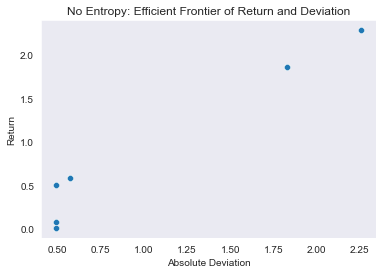

In [28]:
sns.set_style("dark")
rd_NoEntropy = sns.scatterplot(x='w_star', y = 'r_star', data = df_efficient_frontier)
rd_NoEntropy = rd_NoEntropy.set(xlabel ="Absolute Deviation", ylabel = "Return", title ='No Entropy: Efficient Frontier of Return and Deviation')

plt.savefig("Efficient Frontier for Non Entropy Model")

> In Multi-Objective Optimization, the efficient frontier is often referred as the **Pareto front**. The idea is to take out of scope every **dominated solution** (being outperfomed on every single objective by another solution in the dataset). The efficient frontier is then approximated with a trendline (or hyperplane) over the remaining datapoints. In this case, the problem being non-linear and the solution not guaranteed to be optimal, the next step is to "visually approximate" where the efficient frontier would be and plan how it would be shaped.
>
> Then, we look at the efficient frontiers in regards to every **pairwise relationship** between expected return, absolute deviation, and entropy.

In [29]:
 #Efficient Frontier
first_run  = 0
if first_run == 1:
    df_efficient_frontier_made = pd.DataFrame(columns=['Alpha','Beta','Gamma','r_star','w_star','h_star'])
    step = 0.1
    for Alpha in np.arange(0,1.2,step):
        for Beta in np.arange(0,step + 1 - Alpha,step):
            if (Alpha + Beta) == 1:
                Gamma = 0
            else:
                Gamma = 1 - (Alpha + Beta) 
            x_star = solve_made_gd(Alpha, Beta, Gamma)
            r_star = RX(x_star)
            w_star =  WX(x_star)
            h_star =  HX(x_star)
            d = {'Alpha' : Alpha, 'Beta' : Beta, 'Gamma' : Gamma, 'r_star' : r_star, 'w_star' : w_star, 'h_star' : h_star}
            df_temp_made = pd.DataFrame(data=d, index = [int(Alpha*(1/step))])
            df_efficient_frontier_made = pd.concat([df_efficient_frontier_made, df_temp_made], axis=0)

In [30]:
#df_efficient_frontier_made.to_csv('efficient_frontier_made.csv', index=False)
df_efficient_frontier_made = pd.read_csv('efficient_frontier_made.csv')

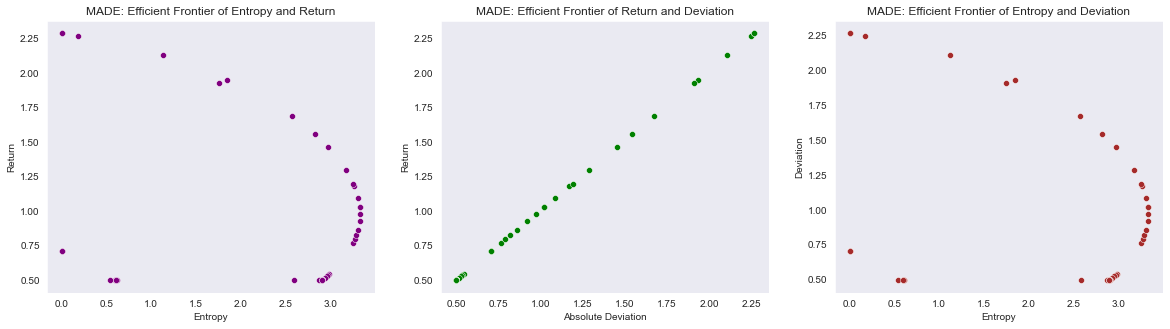

In [31]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
er_Entropy = sns.scatterplot(x='h_star', y = 'r_star', data = df_efficient_frontier_made, color = "purple")
er_Entropy = er_Entropy.set(xlabel ="Entropy", ylabel = "Return", title ='MADE: Efficient Frontier of Entropy and Return')

plt.subplot(1,3,2)
rd_Entropy = sns.scatterplot(x='w_star', y = 'r_star', data = df_efficient_frontier_made,color="green")
rd_Entropy = rd_Entropy.set(xlabel ="Absolute Deviation", ylabel = "Return", title ='MADE: Efficient Frontier of Return and Deviation')

plt.subplot(1,3,3)
ed_Entropy = sns.scatterplot(x='h_star', y = 'w_star', data = df_efficient_frontier_made, color = "brown")
ed_Entropy = ed_Entropy.set(xlabel ="Entropy", ylabel = "Deviation", title ='MADE: Efficient Frontier of Entropy and Deviation')

plt.savefig("Efficient Frontiers for MADE Model")

> ### Monte-Carlo Bootstrapping 
> In some ways, despite falling under the prescriptive analytics umbrella, this problem could be considered as some sort of predictive modelling. The goal being "predicting the optimal weghts" that will minimize the objective function (loss) with future price data. In that regard, minimizing the variance of the model is as critical as it is in a machine learning task. One approach to check robustness and replicability is to perform **cross-validation**.
> ### Data Bootstrap 
> **Bootstrapping** is a method that consists of randomly re-sampling a selected dataset to generate multiple other simulated samples. In this context, it is primarily used to test the replicability and **low variance** of the model in the future to make sure that the results obtained were not simply **overfitting** the training dataset based on historical data bias *(Jirong, 2021)*.
>
> While there are multiple different methods of bootstrapping, the method used here is referred to as **block bootstrapping**. Block bootstrapping is a method of bootstrapping the randomly-sampled blocks of data from the main dataset to create simulated ones.<br><br>
> For instance, consider a sample dataset of 10 observations: $A = [1,2,3,4,5,6,7,8,9,10]$. if the intention is to create a random sample of size five, **Single observation bootstrapping** will create a dataset of five random numbers from $A$ eg: $[2,7,9,1,5]$. **Blocked bootstrapping** on the other hand will create a sample of five using consecutive observations eg: $[3,4,5,9,10]$<br><br>
>While one can choose to have a set length of sets that the blocked bootstrap method uses, we opt to have random lengths of blocks to further increase the randomness in the sample and test the model to a further degree. Therefore, the sets of observations within that sample are a random number of consecutive observations.
>
> This method is used because the data in question deals with stock prices. It is reasonable to assume that today's stock prices are **not independent** from yesterday's, therefore resulting in a time series. The blocked bootstrap allows the simulated samples to maintain this time series while still introducing randomness to allow for testing.

In [32]:
def randomized_blocked_bootstrapping():
    rb_bs_index = []
    while len(rb_bs_index) < len(rjt):
        start_ind_block = random.randint(1, len(rjt)-1)
        len_block = random.randint(1, min((len(rjt)-start_ind_block), (len(rjt)-len(rb_bs_index)),12))
        for i in range(len_block):
            rb_bs_index.append(start_ind_block + i - 1)
    rb_bs_df = rjt.dropna().iloc[rb_bs_index, :]
    return rb_bs_df

In [33]:
# Randomized blocked bootstrapping
bs_size = 500
dic_df_rbbs = {iter: randomized_blocked_bootstrapping() for iter in range(bs_size)}
#for iter in range(10):
    #print(dic_df_rbbs[iter])

> ### Cross-Validation
>
> From this point onwards, we will consider that inverstors allocate equal importance towards every single objective: Expected Return, Absolute Deviation and Entropy being $\alpha = \beta = \gamma = 1$. Now that we produced a bootsrapped dataset of the historical data, it is time to move on to the robustness check of our model, often referred to as the cross-validation step in machine learning.<br/><br/>
> **Model Output:**

In [34]:
Alpha = 1
Beta = 1
Gamma = 1
x_star = solve_made_gd(Alpha, Beta, Gamma)

> **Define function to compute expected return and absolute deviation on bootstrapped datasets**:

In [35]:
def RX_CV(x, bs_rjt):
    RX = 0
    bs_rj = comp_return(bs_rjt).tail(1) - 1
    for j in Tickers:
        RX = RX + x[Tickers.index(j)] * bs_rj[j + '_rjt'][len(bs_rjt)-1]
    return RX

def WX_CV(x, bs_rjt):
    WX = 0
    bs_rj = comp_return(bs_rjt).tail(1) - 1
    for t in range(1,len(bs_rjt)):
        SubSum = 0
        for j in range(len(x)):
            SubSum = SubSum + x[j] * (bs_rjt.iloc[t,j] - bs_rj.iloc[0,j])
        WX = WX + abs(SubSum)
    WX = (1/len(bs_rjt)) * WX
    return WX

> **Model computation on bootstraped datasets** <br/>
> Let's first retrieve objective value.

In [36]:
df_bs_obj = pd.DataFrame(columns=['BS','r_star','w_star'])

for iter in range(bs_size):
    d = {'BS' : iter, 'r_star' : RX_CV(x_star,dic_df_rbbs[iter]), 'w_star' : WX_CV(x_star,dic_df_rbbs[iter])}
    df_temp_bs_obj = pd.DataFrame(data=d, index = [iter])
    df_bs_obj = pd.concat([df_bs_obj, df_temp_bs_obj], axis=0) 

> Let's now compute returns overtime to feed future plots.

In [37]:
time_period_index = list(range(len(dic_df_rbbs[0])))
bs_rjt = x_star*dic_df_rbbs[0]
bs_rjt = pd.DataFrame(data = bs_rjt.transpose().sum())
bs_rjt.index = time_period_index
bs_rjt = pd.DataFrame(bs_rjt).transpose()

for iter in range(1,bs_size):
    bs_rjt_temp = x_star*dic_df_rbbs[iter]
    bs_rjt_temp = pd.DataFrame(data = bs_rjt_temp.transpose().sum())
    bs_rjt_temp.index = time_period_index
    bs_rjt_temp = pd.DataFrame(bs_rjt_temp).transpose()
    bs_rjt = pd.concat([bs_rjt, bs_rjt_temp], axis=0) 

bs_df_index = list(range(len(bs_rjt)))
bs_rjt.index = bs_df_index

> ### Data Visualization
> Lastly, out of the cross-validation steps, we first want to observe the distribution of the expected return and absolute deviation of our portfolio over the bootstrapped datasets. These bootstrapped datasets could also be interpreted as different plausible versions of what could have been the reality over this amount of time. 
>
> At first, the histogram will give us information about the **distribution** of the **key performances indicators** over these different simulated realities as well as a 95% visual **confidence interval**.    

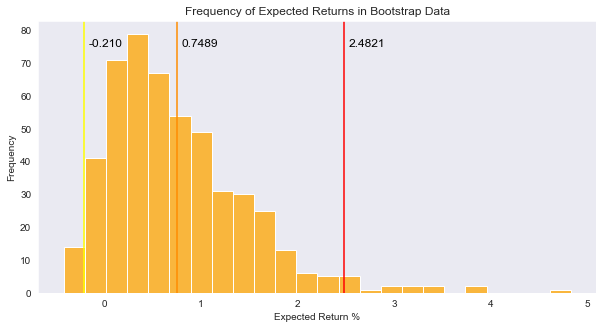

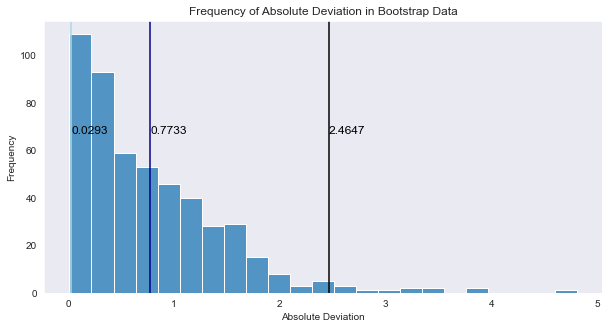

In [38]:
# Font Dict
font = {'family':'sans-serif','color':'black','size':12}

#Histogram Expected Return
fig, ax = plt.subplots(figsize = (10,5))
ER_hist = sns.histplot(df_bs_obj,  x='r_star', color = "orange")
ER_hist = ER_hist.set(xlabel ="Expected Return %", ylabel = "Frequency", 
            title ='Frequency of Expected Returns in Bootstrap Data')
plt.axvline(x = df_bs_obj.r_star.mean(), color = "darkorange")
plt.axvline(x = df_bs_obj.r_star.quantile(0.975), color = "red")
plt.axvline(x = df_bs_obj.r_star.quantile(0.025), color = "yellow")
plt.text(df_bs_obj.r_star.mean() + 0.05, 75, str(df_bs_obj.r_star.mean().round(4)), fontdict = font)
plt.text(df_bs_obj.r_star.quantile(0.975) + 0.05, 75, str(df_bs_obj.r_star.quantile(0.975))[:6], fontdict = font)
plt.text(df_bs_obj.r_star.quantile(0.025) + 0.05, 75, str(df_bs_obj.r_star.quantile(0.025))[:6], fontdict = font)
plt.savefig("Frequency of Expected Returns in Bootstrap Data")

#Histogram Absolute Deviation
fig, ax = plt.subplots(figsize = (10,5))
AD_hist = sns.histplot(df_bs_obj, x='w_star')
AD_hist = AD_hist.set(xlabel ="Absolute Deviation", ylabel = "Frequency", 
            title ='Frequency of Absolute Deviation in Bootstrap Data')
plt.axvline(x = df_bs_obj.w_star.mean(), color = "darkblue")
plt.axvline(x = df_bs_obj.w_star.quantile(0.975), color = "black")
plt.axvline(x = df_bs_obj.w_star.quantile(0.025), color = "lightblue")
plt.text(df_bs_obj.w_star.mean()  + 0.0001, 67, str(df_bs_obj.w_star.mean().round(4)), fontdict = font)
plt.text(df_bs_obj.w_star.quantile(0.975) + 0.0001, 67, str(df_bs_obj.w_star.quantile(0.975))[:6], fontdict = font)
plt.text(df_bs_obj.w_star.quantile(0.025) + 0.0001, 67, str(df_bs_obj.w_star.quantile(0.025))[:6], fontdict = font)
plt.savefig("Frequency of Absolute Deviation in Bootstrap Data")

> Finally, a famous graph in Monte-Carlo portfolio optimization is the following, observing how a portfolio would perform **over time** on every single reality.

In [39]:
cum_rjt = cum_rjt - 1

In [40]:
def comp_return_bs(bs_rjt, iter):
    com_ret_bs = []
    com_ret_bs.append(1 * (1 + bs_rjt[0][iter]))
    for j in range(1,len(rjt)):
        com_ret_bs.append(com_ret_bs[j-1] * (1 + bs_rjt[j][iter]))
    for j in range(len(rjt)):
        com_ret_bs[j] = com_ret_bs[j] - 1
    return com_ret_bs

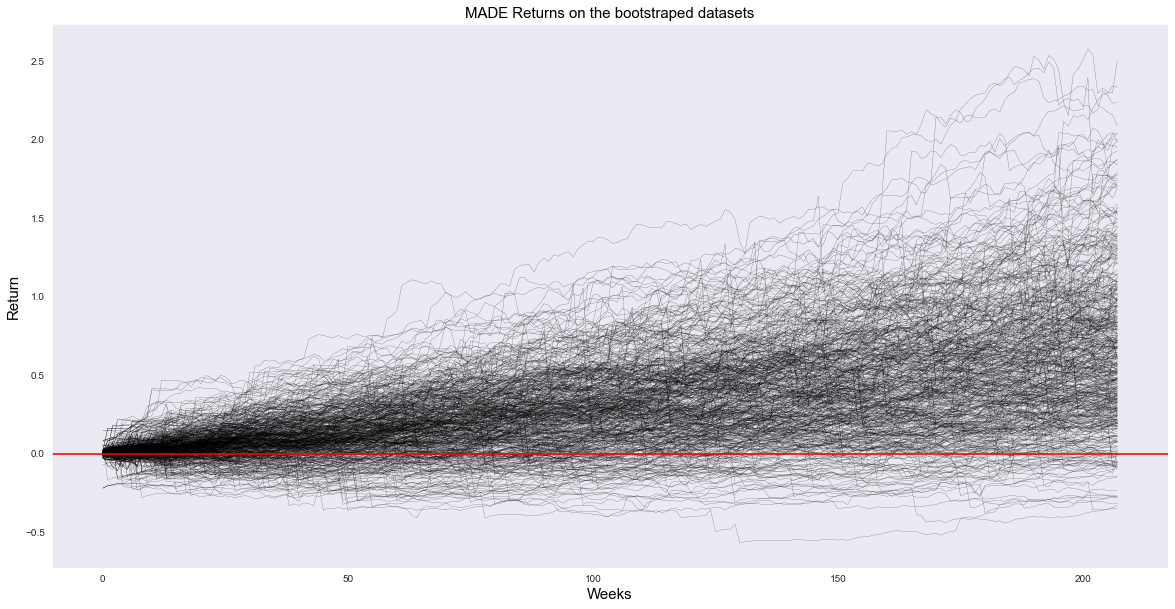

In [41]:
plt.figure(figsize=(20,10))

#Time periods
x = time_period_index

#Naive Strategy
naive_x = 1/len(Tickers)

# Actual Market
full_rjt = naive_x * pd.DataFrame(data =  cum_rjt.transpose().sum())
full_rjt = pd.DataFrame(full_rjt).transpose()

#Market Real Performance
font1 = {'family':'sans-serif','color':'black','size':15}
font2 = {'family':'sans-serif','color':'black','size':15}
for iter in range(len(bs_rjt)):
    plt.plot(x, comp_return_bs(bs_rjt.iloc[[iter]], iter),'black',linewidth = 0.2, alpha = 0.8)
plt.axhline(0, color = 'r', linewidth=2, alpha = 0.8)
plt.xlabel("Weeks", fontdict = font2)
plt.ylabel("Return", fontdict = font2)
plt.title("MADE Returns on the bootstraped datasets", fontdict = font1)

plt.savefig("MADE Returns on the bootstraped datasets", dpi=150)

plt.show()

*** 
## Conclusion
It is important to mention that this model is purely quantitative and driven by market data. From an investing point of view, this model lacks consideration of **external factors** like macroeconomic forecasts, industry diversification, geopolitical events, etc. Considering these extra-market factors and information would enhance the quality of the portfolio created. 

Additionally, from a technical perspective, the **cross-validation** step comes posteriori, simply as a performance benchmark of the quality of the model. However, it will not impact the model nor fix it if it were to indicate poor performance, being a purely descriptive tool.

Reducing **bias**, and especially **variance**, is an essential task in machine learning. Sampling and resampling cross-validation techniques such as K-Fold and BootStrapping *(Patro, 2021)*, inspired techniques like **Bagging** and **Boosting** to reinforce the model-building phase of a machine learning process. This allows for control over the sensitivity of the model towards the training data and find good **Bias-Variance** trade-off, far away from the overfitting and underfitting traps. 

In this specific project, being entirely dependent on the training data is undesirable. The training data is reflective of the past, and more likely than not, the past will never be repeated in an identical manner. Nonetheless, the past still carries information about the future. The idea is to capture the right amount of information from the past to do well in predicting what is likely to happen in the future. Hence, further work on the training data before running the model could help increase the reproducibility of the model on upcoming data (future stock price). Unfortunately, only one reality is observable and unpredictable, so measuring the actual benefit of such a technique is impossible due to the unobservability of the counterfactual scenarios.

*** 
## References

Lam, Lam, W. H., & Jaaman, S. H. (2021). Portfolio Optimization with a Mean–Absolute Deviation–Entropy Multi-Objective Model. Entropy (Basel, Switzerland), 23(10), 1266–. https://doi.org/10.3390/e23101266

Konno, & Yamazaki, H. (1991). Mean-Absolute Deviation Portfolio Optimization Model and Its Applications to Tokyo Stock Market. Management Science, 37(5), 519–531. https://doi.org/10.1287/mnsc.37.5.519

Markowitz. (1952). Portfolio Selection. The Journal of Finance (New York), 7(1), 77–. https://doi.org/10.2307/2975974

Shannon, C. E. (1948). A mathematical theory of communication. Bell System Technical Journal, 27(4), 623-656. https://doi.org/10.1002/j.1538-7305.1948.tb00917.x

Kraft, Dieter (July 1988). A software package for sequential quadratic programming. Technical Report DFVLR-FB 88-28. Oberpfaffenhofen: Institut für Dynamik der Flugsysteme. Retrieved 13 October 2022

Jirong. (2021, January 16). Bootstrapindex, a python package with walk forward analysis and block bootstrapping capability. Medium. https://medium.datadriveninvestor.com/bootstrapindex-a-python-package-with-walk-forward-analysis-and-block-bootstrapping-capability-7ae71ee9f107. Retrieved 21 October 2022.

Patro, R. (2021, February 1). Cross validation: K fold vs Monte Carlo. Medium. https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b

Bertsimas, Darnell, C., & Soucy, R. (1998). Portfolio construction through mixed integer programming. IDEAS Working Paper Series from RePEc.

Guerard, Gillam, R. A., Markowitz, H., Xu, G., Deng, S., & Wang, Z. “Elaine.” (2018). Data Mining Corrections Testing in Chinese Stocks. Interfaces (Providence), 48(2), 108–120. https://doi.org/10.1287/inte.2017.0908

Chalermkraivuth, Bollapragada, S., Clark, M. C., Deaton, J., Kiaer, L., Murdzek, J. P., Neeves, W., Scholz, B. J., & Toledano, D. (2005). GE Asset Management, Genworth Financial, and GE Insurance Use a Sequential-Linear-Programming Algorithm to Optimize Portfolios. Interfaces (Providence), 35(5), 370–380. https://doi.org/10.1287/inte.1050.0164